<a href="https://colab.research.google.com/github/c0pper/stylometry/blob/main/expertiment_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive2', force_remount=True)

In [1]:
!pip install transformers neptune-client neptune-tensorflow-keras --quiet
!cp /content/drive2/MyDrive/simo/tokens.py /content

     |████████████████████████████████| 4.9 MB 9.4 MB/s 
     |████████████████████████████████| 326 kB 72.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.6 MB 49.4 MB/s 
     |████████████████████████████████| 120 kB 53.6 MB/s 
     |████████████████████████████████| 829 kB 57.1 MB/s 
     |████████████████████████████████| 55 kB 1.4 MB/s 
     |████████████████████████████████| 181 kB 54.6 MB/s 
     |████████████████████████████████| 132 kB 55.9 MB/s 
     |████████████████████████████████| 56 kB 1.9 MB/s 
     |████████████████████████████████| 79 kB 8.1 MB/s 
     |████████████████████████████████| 9.2 MB 51.7 MB/s 
     |████████████████████████████████| 140 kB 63.4 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 127 kB 76.2 MB/s 
     |████████████████████████████████| 130 kB 75.1 MB/s 
     |███████

In [8]:
from typing import Union
import math 
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from datetime import datetime
import joblib
from tqdm import tqdm
from transformers import TFBertModel, BertTokenizer
import numpy as np
from tensorflow import keras
from requests import get
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
from tensorflow.keras.models import load_model
import time
import json
from tensorflow.keras.layers import Dense, Dropout
import os
from tqdm import tqdm
tqdm.pandas()
import neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

from tokens import neptune_token

MODEL_SAVEPATH = "/content/drive/MyDrive/simo/"
TIMENOW = datetime.now().strftime('%d-%m-%y-%H-%M')

os.makedirs("/content/drive/MyDrive/simo/logs", exist_ok=True)
os.makedirs("/content/drive/MyDrive/simo/logs/sklearn", exist_ok=True)
os.makedirs("/content/drive/MyDrive/simo/logs/bert", exist_ok=True)
os.makedirs("/content/drive/MyDrive/simo/logs/stylo", exist_ok=True)
os.makedirs("/content/drive/MyDrive/simo/models", exist_ok=True)
os.makedirs("/content/drive/MyDrive/simo/models/sklearn", exist_ok=True)
os.makedirs("/content/drive/MyDrive/simo/models/bert", exist_ok=True)
os.makedirs("/content/drive/MyDrive/simo/models/stylo", exist_ok=True)

def merge_datasets(dataset_list: list, target_col: str):
  round_threshold = 0.49
  processed_datasets = []
  list90 = []
  list10 = []

  for idx, d in enumerate(dataset_list):
    print(f"original dataset {idx} shape", d.shape)
    original_shape = d.shape[0]

    d90 = pd.DataFrame()
    d10 = pd.DataFrame()
    values_form_target = pd.unique(d[target_col].squeeze())
    values_shapes = []
    for v in values_form_target:
      d_label = d[(d[target_col] == v)]
      # print(d_label[target_col])
      value_shape = d_label.shape[0]
      values_shapes.append(value_shape)

      d_label90perc, d_label10perc = np.split(d_label, [int(.9*len(d_label))])
      print(f"shape 90% for {v}: {d_label90perc.shape[0]} == shape*0.9: {value_shape*0.9}")
      print(f"shape 10% for {v}: {d_label10perc.shape[0]} == shape*0.1: {value_shape*0.1}")

      d90 = d90.append(d_label90perc, ignore_index=True) # unisco i 2 sottodataset contenenti solo label1 e label2
      d10 = d10.append(d_label10perc, ignore_index=True) # unisco i 2 sottodataset contenenti solo label1 e label2
    assert(sum(values_shapes) == original_shape)
    
    d90 = d90.sample(frac=1, random_state=42) # mischio le righe per evitare che ci siano prima tutti label1 e poi tutti label2
    d10 = d10.sample(frac=1, random_state=42)
    assert((d90.shape[0] + d10.shape[0]) == original_shape)

    print("\n90% of dataset\n", d90.groupby(target_col)[target_col].count())# stampo il conteggio delle classi presenti nella nuova coppia di dataset derivata dall'originale
    print("\n10% of dataset\n", d10.groupby(target_col)[target_col].count(), "\n\n\n")
    processed_datasets.append((d90, d10))

  for tup in processed_datasets:
    df90 = tup[0]
    df10 = tup[1]
    list90.append(df90)
    list10.append(df10)
  merged90 = pd.DataFrame()
  merged10 = pd.DataFrame()
  for df in list90:
    merged90 = merged90.append(df)
  for df in list10:
    merged10 = merged10.append(df)

  return(merged90, merged10)

def preprocess(text,stem=False):
    stop_words = stopwords.words('english')
    stemmer = SnowballStemmer('english')
    lemmatizer = WordNetLemmatizer()
    
    text = text.lower()  # lowercase

    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r'â€™', "'", text)
    text = re.sub(r'â€œ', "'", text)
    text = re.sub(r'â€', "'", text)
    text = re.sub(r'â€˜', "'", text)
    text = re.sub(r'â‚¬', "€", text)
    text = re.sub(r"'", "", text)
    text = re.sub('\s+', ' ', text).strip()  # Remove and double spaces
    text = re.sub(r'&amp;?', r'and', text)  # replace & -> and
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)  # Remove URLs
    # remove some puncts (except . ! # ?)
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'EMOJI', text)
    
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmatizer.lemmatize(token))
    return " ".join(tokens)



def apply_preprocess(xtrain, xvalid):
  print("\nPreprocessing texts...")
  print(f"\nBefore: {(xtrain.iloc[0][:50] + '..') if len(xtrain.iloc[0]) > 50 else xtrain.iloc[0]}")
  xtrain = xtrain.progress_apply(lambda x: preprocess(x))
  xvalid = xvalid.progress_apply(lambda x: preprocess(x))
  print(f"\nAfter: {(xtrain.iloc[0][:50] + '..') if len(xtrain.iloc[0]) > 50 else xtrain.iloc[0]}")

  return xtrain, xvalid


class Experiment:
  scaler = StandardScaler()
  lbl_enc = preprocessing.LabelEncoder()

  def __init__(self, dataset_path: Union[str, pd.DataFrame], split_size: float, target_col: str, model_savepath=MODEL_SAVEPATH):
    self.dataset_path = dataset_path
    self.split_size = split_size
    self.target_col = target_col
    if isinstance(self.dataset_path, str):
      self.dataset_name = dataset_path.split(".")[-2].split("/")[-1]
    elif isinstance(self.dataset_path, pd.DataFrame):
      self.dataset_name = input("Dataset name not found. Please enter dataset name: ")
    self.model_savepath = model_savepath
    self.nb_name = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].split(".")[0]
    self.nb_url = "https://colab.research.google.com/drive/" + get('http://172.28.0.2:9000/api/sessions').json()[0]["path"].split("=")[-1]

    self.run = neptune.new.init(project="c0pper/fake-news", api_token=neptune_token)


  def load_split_dataset(self, dataset_path, dropna=False, do_split=True, use_scaler=False):
    if isinstance(dataset_path, str): 
      format = dataset_path.split(".")[-1]
      valid = {"csv", "xlsx", "xls"}
      if format not in valid:
        raise ValueError(f"results: status must be one of {valid}.")
      elif format == "csv":
        dataset = pd.read_csv(dataset_path)
      elif (format == "xlsx" or format == "xls"):
        dataset = pd.read_excel(dataset_path)
    else:
      dataset = dataset_path

    print("Dataset head\n") 
    print(dataset.head())

    X = dataset.drop(self.target_col, axis=1)
    y = self.lbl_enc.fit_transform(dataset[self.target_col].values)

    #dropping nans
    if dropna:
      print("DROPPING NAN")
      dataset = dataset.dropna(axis=0, how='any')

    if use_scaler:
      X = self.scaler.fit_transform(X)

    
    listy = list(self.lbl_enc.inverse_transform(y))
    print("Dataset class distribution:")
    for i in set(listy):
      print(i, listy.count(i))

    if do_split:
      xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=self.split_size, shuffle=True)
      return xtrain, xvalid, ytrain, yvalid
    else:
      return X, y


  def print_cm(self, yvalid, predicted, target_names=[]): 
    cm = metrics.confusion_matrix(yvalid, predicted)
    disp = metrics.ConfusionMatrixDisplay(cm, display_labels=target_names)
    disp.plot(xticks_rotation="vertical")

  def print_report(self, predicted, yvalid, target_names=None):
    report_dict = metrics.classification_report(yvalid, predicted, target_names=[str(x) for x in target_names], output_dict=True)
    report_text = metrics.classification_report(yvalid, predicted, target_names=[str(x) for x in target_names])
    print(report_text)
    self.print_cm(yvalid, predicted, target_names=target_names)
    return report_dict

  
  def load_test_dataset(self, testdataset_path, dropna):
    X, y = self.load_split_dataset(testdataset_path, dropna=dropna, do_split=False)
    target_names = self.lbl_enc.inverse_transform(list(set(y)))
    return X, y, target_names


  def confirm_stop_traking(self):    
    tracking_stop_confirmation = input(f"Stop neptune traking? Continue if you want to do evaluation (y/n)")
    if tracking_stop_confirmation == "y":
      self.run.stop()
      print(f"Traking stopped")
    else:
      print(f"Continuing neptune tracking")

  def track_eval_metrics_neptune(self, report_dict: dict, modelpath: str, testdataset_path: str, exp_type: str):
    test_ds_name = testdataset_path.split("/")[-1]

    self.run[f"eval_parameters/{test_ds_name}"] = report_dict
    self.run[f"eval_parameters/{test_ds_name}/model_path"] = modelpath
    self.run["sys/tags"].add(["eval", exp_type])
    self.run[f"eval_parameters/{test_ds_name}/dataset_path"] = testdataset_path
    self.run[f"eval_parameters/{test_ds_name}/dataset_name"] = test_ds_name


class PublicExpertiment(Experiment):
  def __init__(self, dataset_path: Union[str, pd.DataFrame], split_size: float, target_col: str, text_col: str, model_savepath=MODEL_SAVEPATH, preprocess_dataset=True):
    super().__init__(dataset_path, split_size, target_col, model_savepath)
    self.text_col = text_col
    self.preprocess_dataset = preprocess_dataset


class ScikitExperiment(PublicExpertiment):
  def __init__(self, dataset_path: Union[str, pd.DataFrame], split_size: float, target_col: str, text_col: str, algo, model_savepath=MODEL_SAVEPATH, preprocess_dataset=True):
    super().__init__(dataset_path=dataset_path, 
                     split_size=split_size, 
                     target_col=target_col, 
                     text_col=text_col, 
                     model_savepath=model_savepath, 
                     preprocess_dataset=preprocess_dataset
                     )
    self.algo = algo


  def train(self, dropna=False):
    start = time.time()
    xtrain, xvalid, ytrain, yvalid = super().load_split_dataset(self.dataset_path, dropna=dropna)
    xtrain = xtrain[self.text_col]
    xvalid = xvalid[self.text_col]

    if self.preprocess_dataset:
      xtrain, xvalid = apply_preprocess(xtrain, xvalid)
      
    clf_pipeline = Pipeline([
     ('ctv', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', self.algo),
    ])
    print(f"Fitting pipeline: {clf_pipeline}")
    clf_pipeline.fit(xtrain, ytrain)
    end = time.time()
    elapsed = round(end - start, 2)
    predicted = clf_pipeline.predict(xvalid)
    report = super().print_report(predicted, yvalid, target_names=self.lbl_enc.inverse_transform(list(set(yvalid))))

    self.save_model(clf_pipeline, self.lbl_enc)
    print("Time elapsed in seconds: ", round(elapsed, 2))
    
    log_dict = self.log(self.model_savepath, self.dataset_name, len(xtrain)+len(xvalid), type(self.algo).__name__, elapsed, report)

    self.confirm_stop_traking()

    return log_dict

  
  def save_model(self, model, lbl_enc):
    algo_name = type(self.algo).__name__
    experiment_name = self.nb_name+"__"+self.dataset_name+"__"+algo_name
    save_confirmation = input(f"Save model {experiment_name}? (y/n)")
    if save_confirmation == "y":
      filepath = f'{self.model_savepath}models/sklearn/{experiment_name}.pkl'
      print(f"Saving model to {filepath}")
      data = {
          "model": model,
          "lbl_enc": lbl_enc
      }
      joblib.dump(data, filepath)
      self.run["model/model_was_saved"] = True
      self.run["model/model_location"] = filepath
    else:
      print("Model wasn't saved")
      self.run["model/model_was_saved"] = False


  def load_model_and_predict(self, modelpath, X):
    data = joblib.load(modelpath, mmap_mode=None)
    model = data["model"] #sklearn  
    predicted = model.predict(X) 
    return predicted


  def evaluate_on_other_dataset(self, testdataset_path: Union[str, pd.DataFrame], modelpath: str, dropna=False):
    start = time.time()
    if isinstance(testdataset_path, str):
      format = testdataset_path.split(".")[-1]
      valid = {"csv", "xlsx", "xls"}
      if format not in valid:
        raise ValueError(f"results: status must be one of {valid}.")
      elif format == "csv":
        dataset = pd.read_csv(testdataset_path)
      elif (format == "xlsx" or format == "xls"):
        dataset = pd.read_excel(testdataset_path)
      X = dataset[self.text_col]
      y = dataset[self.target_col]
    elif isinstance(testdataset_path, pd.DataFrame):
      X = testdataset_path[self.text_col]
      y = testdataset_path[self.target_col]
    print(X.shape)

    if self.preprocess_dataset:
      print("Preprocessing text...")
      X = X.progress_apply(lambda x: preprocess(x))
    target_names = list(set(y))
    lbl_enc = joblib.load(modelpath, mmap_mode=None)["lbl_enc"]

    predicted = self.load_model_and_predict(modelpath, X)
    report_dict = super().print_report(predicted, lbl_enc.transform(y), target_names)
    end = time.time()
    elapsed = round(end - start, 2)
    print("Time elapsed in seconds: ", round(elapsed, 2))
    self.track_eval_metrics_neptune(report_dict, modelpath, testdataset_path, "sklearn")
    self.confirm_stop_traking()


  def log(self, savepath, datasetname, dataset_len, algo, elapsed, report):
    log_dict = {
        "library_used": type(self).__name__,
        "dataset_name": datasetname,
        "dataset_lenght": dataset_len,
        "notebook_url": self.nb_url,
        "algo": algo,
        "elapsed": elapsed,
        "metrics_report": report
    }
    algo_name = type(self.algo).__name__
    experiment_name = self.nb_name+"__"+self.dataset_name+"__"+algo_name
    filepath = f'{savepath}logs/sklearn/{experiment_name}_log.json'
    with open(filepath, 'w') as fp:
      json.dump(log_dict, fp)
      print("Log saved to ", filepath)

    self.run["parameters"] = log_dict
    self.run["sys/tags"].add(["sklearn","training"])

    return log_dict


class TFExperiment(PublicExpertiment):
  def __init__(self, dataset_path: Union[str, pd.DataFrame], split_size: float, text_col, target_col: str, preprocess_dataset=True, model_savepath=MODEL_SAVEPATH, bert_pretrained_model='bert-large-uncased', bert_encode_maxlen=60):
    super().__init__(dataset_path=dataset_path, 
                     split_size=split_size, 
                     text_col=text_col, 
                     target_col=target_col, 
                     preprocess_dataset=preprocess_dataset, 
                     model_savepath=model_savepath)
    self.bert_pretrained_model = bert_pretrained_model
    self.bert_encode_maxlen = bert_encode_maxlen
  

  def bert_encode(self, data, max_len) :
    bert_tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
    input_ids = [] 
    attention_masks = []
    
    for i in tqdm(range(len(data))):
        encoded = bert_tokenizer.encode_plus(data.iloc[i],
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)


  def create_model(self, bert_encode_maxlen, bert_pretrained_model, optimizer, loss, metrics):
    bert_layers = TFBertModel.from_pretrained(bert_pretrained_model)

    input_ids = keras.Input(shape=(bert_encode_maxlen,),dtype='int32',name='input_ids')
    attention_masks = keras.Input(shape=(bert_encode_maxlen,),dtype='int32',name='attention_masks')

    output = bert_layers([input_ids,attention_masks])
    output = output[1]
    net = keras.layers.Dense(32,activation='relu')(output)
    net = keras.layers.Dropout(0.2)(net)
    net = keras.layers.Dense(1,activation='sigmoid')(net)
    outputs = net
    model = keras.models.Model(inputs = [input_ids,attention_masks],outputs = outputs)

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metrics])
    
    model.summary()
    return model


  def train(self, bert_encode_maxlen=None, bert_pretrained_model=None, dropna=False, epochs=10, optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics='accuracy', callbacks=[]):
    start = time.time()
    if bert_encode_maxlen is None:
      bert_encode_maxlen = self.bert_encode_maxlen
    if bert_pretrained_model is None:
      bert_pretrained_model = self.bert_pretrained_model

    xtrain, xvalid, ytrain, yvalid = super().load_split_dataset(self.dataset_path, dropna=dropna)
    xtrain = xtrain[self.text_col]
    xvalid = xvalid[self.text_col]

    if self.preprocess_dataset:
      xtrain, xvalid = apply_preprocess(xtrain, xvalid)

    train_input_ids, train_attention_masks = self.bert_encode(xtrain, bert_encode_maxlen)
    val_input_ids, val_attention_masks = self.bert_encode(xvalid, bert_encode_maxlen)

    model = self.create_model(bert_encode_maxlen, bert_pretrained_model, optimizer=optimizer, loss=loss, metrics=metrics)

    neptune_cbk = NeptuneCallback(run=self.run, base_namespace='metrics')

    history = model.fit(
    [train_input_ids, train_attention_masks],
    ytrain,
    epochs=epochs,
    # validation_data=([val_input_ids, val_attention_masks], y_val),
    batch_size=32,
    callbacks=[neptune_cbk]
    )
    end = time.time()
    elapsed = round(end - start, 2)

    predicted = model.predict([val_input_ids, val_attention_masks])
    predicted = np.array(list(round(i[0]) for i in predicted))
    report = super().print_report(predicted, yvalid, target_names=self.lbl_enc.inverse_transform(list(set(yvalid))))

    self.save_model(model, self.lbl_enc)
    print("Time elapsed in seconds: ", round(elapsed, 2))
    
    log_dict = self.log(self.model_savepath, self.dataset_name, model, len(xtrain)+len(xvalid), elapsed, bert_encode_maxlen, epochs, bert_pretrained_model, optimizer, report)
    self.confirm_stop_traking()
  
  def save_model(self, model, lbl_enc):
    algo_name = type(model).__name__
    experiment_name = self.nb_name+"__"+self.dataset_name+"__"+algo_name
    save_confirmation = input(f"Save model {experiment_name}? (y/n)")
    if save_confirmation == "y":
      filepath = f'{self.model_savepath}models/bert/{experiment_name}.h5'
      lbl_enc_path = f'{self.model_savepath}models/bert/{experiment_name}__lbl_enc.pkl'
      data = {
          "model": model,
          "lbl_enc": lbl_enc
      }
      print(f"Saving model to {filepath}")
      # joblib.dump(data, filepath)
      joblib.dump(lbl_enc, lbl_enc_path)
      model.save(f'{self.model_savepath}models/bert/{experiment_name}.h5')
      self.run["model/model_was_saved"] = True
      self.run["model/model_location"] = filepath
    else:
      print("Model wasn't saved")
      self.run["model/model_was_saved"] = False


  def load_model_and_predict(self, modelpath, X):
    # data = joblib.load(modelpath, mmap_mode=None)
    # model = data["model"]
    model = load_model(modelpath, custom_objects={'TFBertModel':TFBertModel.from_pretrained(self.bert_pretrained_model)}) 
    predicted = model.predict(X) 
    predicted = np.array(list(round(i[0]) for i in predicted))
    return predicted


  def evaluate_on_other_dataset(self, testdataset_path, modelpath, text_col, fitted_lbl_enc, dropna=False):
    start = time.time()
    if isinstance(testdataset_path, str):
      format = testdataset_path.split(".")[-1]
      valid = {"csv", "xlsx", "xls"}
      if format not in valid:
        raise ValueError(f"results: status must be one of {valid}.")
      elif format == "csv":
        dataset = pd.read_csv(testdataset_path)
      elif (format == "xlsx" or format == "xls"):
        dataset = pd.read_excel(testdataset_path)
      X = dataset[self.text_col]
      y = dataset[self.target_col]
    elif isinstance(testdataset_path, pd.DataFrame):
      X = testdataset_path[self.text_col]
      y = testdataset_path[self.target_col]
      
    target_names = list(set(y))
    lbl_enc = joblib.load(modelpath, mmap_mode=None)["lbl_enc"]

    if self.preprocess_dataset:
      print("Preprocessing text...")
      X = X.progress_apply(lambda x: preprocess(x))
    input_ids, attention_masks = self.bert_encode(X, self.bert_encode_maxlen)

    predicted = self.load_model_and_predict(modelpath, [input_ids, attention_masks])
    report_dict = super().print_report(predicted, lbl_enc.transform(y), target_names)
    end = time.time()
    elapsed = round(end - start, 2)
    print("Time elapsed in seconds: ", round(elapsed, 2))
    self.track_eval_metrics_neptune(report_dict, modelpath, testdataset_path, "bert")
    self.confirm_stop_traking()


  def log(self, savepath, datasetname, model, dataset_len, elapsed, bert_encode_maxlen, epochs, bert_pretrained_model, optimizer, report):
    log_dict = {
        "library_used": type(self).__name__,
        "dataset_name": datasetname,
        "dataset_lenght": dataset_len,
        "notebook_url": self.nb_url,
        "elapsed": elapsed,
        "bert_encode_maxlen": bert_encode_maxlen,
        "epochs": epochs,
        "bert_pretrained_model": bert_pretrained_model,
        "optimizer": str(optimizer),
        "metrics_report": report
    }
    algo_name = type(model).__name__
    experiment_name = self.nb_name+"__"+self.dataset_name+"__"+algo_name
    filepath = f'{savepath}logs/bert/{experiment_name}_log.json'
    with open(filepath, 'w') as fp:
      json.dump(log_dict, fp)
      print("Log saved to ", filepath)

    self.run["parameters"] = log_dict
    self.run["sys/tags"].add(["bert","training"])

    return log_dict


class StyloExperiment(Experiment):
  def __init__(self, dataset_path: Union[str, pd.DataFrame], split_size: float, target_col: str, model_savepath=MODEL_SAVEPATH):
    super().__init__(dataset_path=dataset_path, 
                     split_size=split_size, 
                     target_col=target_col, 
                     model_savepath=model_savepath)


  def train(self, 
            epochs=10,
            batch_size=512,
            use_scaler=True, 
            n_layers=1, 
            n_units_input=51,
            n_units_per_layer=None,
            dropout_per_layer=None,
            activation="relu",
            learning_rate=0.0014392587661767942,
            optimizer="RMSprop"
            ):
    start = time.time()
    xtrain, xvalid, ytrain, yvalid = super().load_split_dataset(self.dataset_path, use_scaler=use_scaler)

    if not n_units_per_layer:
      n_units_per_layer = [80]
    if not dropout_per_layer:
      dropout_per_layer = [0.3203504513234906]

    nn_parameters = {
      "n_layers": n_layers,
      "n_units_input": n_units_input,
      "activation": activation,
      "n_units_per_layer": n_units_per_layer,
      "dropout_per_layer": dropout_per_layer,
      "learning_rate": learning_rate,
      "optimizer": optimizer
    }

    model = keras.models.Sequential()
    model.add(
        Dense(
            nn_parameters["n_units_input"], 
            input_dim=xtrain.shape[1],
            activation=nn_parameters["activation"],
          )
    )
    for i in range(nn_parameters["n_layers"]):
      model.add(
          Dense(
            nn_parameters["n_units_per_layer"][i],
            activation=nn_parameters["activation"],
          )
      )
      model.add(
          Dropout(nn_parameters["dropout_per_layer"][i])
      )
    model.add(Dense(1, activation="sigmoid"))

    # We compile our model with a sampled learning rate.
    learning_rate = nn_parameters["learning_rate"]
    optimizer_name = nn_parameters["optimizer"]
    model.compile(
        loss="binary_crossentropy",
        optimizer=getattr(keras.optimizers, optimizer_name)(learning_rate=learning_rate),
        metrics=["accuracy"],
    )

    neptune_cbk = NeptuneCallback(run=self.run, base_namespace='metrics')

    history = model.fit(
        xtrain,
        ytrain,
        batch_size=batch_size, 
        epochs=epochs,
        validation_data=(xvalid, yvalid),
        callbacks=[neptune_cbk]
    )
    end = time.time()
    elapsed = round(end - start, 2)

    predicted = model.predict(xvalid)
    predicted = np.array(list(round(i[0]) for i in predicted))
    report = super().print_report(predicted, yvalid, target_names=self.lbl_enc.inverse_transform(list(set(yvalid))))
    self.save_model(model, self.scaler, self.lbl_enc)
    print("Time elapsed in seconds: ", round(elapsed, 2))
    
    log_dict = self.log(self.model_savepath, self.dataset_name, model, len(xtrain)+len(xvalid), elapsed, epochs, nn_parameters, report)
    self.confirm_stop_traking()

  
  def save_model(self, model, scaler, lbl_enc):
    algo_name = type(model).__name__
    experiment_name = self.nb_name+"__"+self.dataset_name+"__"+algo_name+"_stilometria"
    save_confirmation = input(f"Save model {experiment_name}? (y/n)")
    if save_confirmation == "y":
      filepath = f'{self.model_savepath}models/stylo/{experiment_name}.pkl'
      data = {
          "model": model,
          "scaler": scaler,
          "lbl_enc": lbl_enc
      }
      print(f"Saving model to {filepath}")
      joblib.dump(data, filepath)
      # model.save(f'{self.model_savepath}{experiment_name}.h5')
      self.run["model/model_was_saved"] = True
      self.run["model/model_location"] = filepath
    else:
      print("Model wasn't saved")
      self.run["model/model_was_saved"] = False

  def load_model_and_predict(self, modelpath, X):
    data = joblib.load(modelpath, mmap_mode=None)
    model = data["model"]
    predicted = model.predict(X) 
    predicted = np.array(list(round(i[0]) for i in predicted))
    return predicted


  def evaluate_on_other_dataset(self, testdataset_path, modelpath, dropna=False, use_scaler=True):
    start = time.time()
    if isinstance(testdataset_path, str):
      format = testdataset_path.split(".")[-1]
      valid = {"csv", "xlsx", "xls"}
      if format not in valid:
        raise ValueError(f"results: status must be one of {valid}.")
      elif format == "csv":
        testdataset = pd.read_csv(testdataset_path)
      elif (format == "xlsx" or format == "xls"):
        testdataset = pd.read_excel(testdataset_path)
      X = testdataset.drop(self.target_col, axis=1)
      y = testdataset[self.target_col]
    elif isinstance(testdataset_path, pd.DataFrame):
      X = testdataset_path.drop(self.target_col, axis=1)
      y = testdataset_path[self.target_col]

    target_names = list(set(y))
    lbl_enc = joblib.load(modelpath, mmap_mode=None)["lbl_enc"]
    scaler = joblib.load(modelpath, mmap_mode=None)["scaler"]

    if use_scaler:
      X = scaler.transform(X)

    predicted = self.load_model_and_predict(modelpath, X)
    report_dict = super().print_report(predicted, lbl_enc.transform(y), target_names)
    end = time.time()
    elapsed = round(end - start, 2)
    print("Time elapsed in seconds: ", round(elapsed, 2))
    self.track_eval_metrics_neptune(report_dict, modelpath, testdataset_path, "stylo")
    self.confirm_stop_traking()


  def log(self, savepath, datasetname, model, dataset_len, elapsed, epochs, nn_parameters, report):
    log_dict = {
        "library_used": type(self).__name__,
        "dataset_name": datasetname,
        "dataset_lenght": dataset_len,
        "notebook_url": self.nb_url,
        "elapsed": elapsed,
        "epochs": epochs,
        "nueral_net_parameters": nn_parameters,
        "metrics_report": report
    }
    algo_name = type(model).__name__
    experiment_name = self.nb_name+"__"+self.dataset_name+"__"+algo_name+"_stilometria"
    filepath = f'{savepath}logs/stylo/{experiment_name}_log.json'
    with open(filepath, 'w') as fp:
      json.dump(log_dict, fp)
      print("Log saved to ", filepath)

    self.run["parameters"] = log_dict
    self.run["sys/tags"].add(["stylo","training"])

    return log_dict

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Mounted at /content/drive2


In [25]:
import pandas as pd
df = pd.read_csv('/content/drive2/MyDrive/pan17-author-profiling-training-dataset-2017-03-10/en/df_pan2015gender.csv', usecols=["texts", "gender"])

Mounted at /content/drive2


In [26]:
skl = ScikitExperiment(df,0.1,"gender","texts",MultinomialNB())

Dataset name not found. Please enter dataset name: popo
https://app.neptune.ai/c0pper/fake-news/e/FAK-15
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


Dataset head

                                               texts gender
0  Things I want for my business cards but are to...   male
1  "painters produced their most highly valued wo...   male
2  @username your new discussion layout is confus...   male
3  I never really understood why game environment...   male
4  @username 20k and 2048² on a gun, fine. But th...   male
Dataset class distribution:
male 6986
female 7180

Preprocessing texts...

Before: RT @username: Computer Languages Character Distrib..


100%|██████████| 1417/1417 [00:00<00:00, 5055.39it/s]



After: rt username computer language character distributi..
Fitting pipeline: Pipeline(steps=[('ctv', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])
              precision    recall  f1-score   support

      female       0.67      0.78      0.72       735
        male       0.71      0.59      0.65       682

    accuracy                           0.69      1417
   macro avg       0.69      0.69      0.68      1417
weighted avg       0.69      0.69      0.69      1417

Save model expertiment_classes__popo__MultinomialNB? (y/n)y
Saving model to /content/drive/MyDrive/simo/models/sklearn/expertiment_classes__popo__MultinomialNB.pkl
Time elapsed in seconds:  3.09
Log saved to  /content/drive/MyDrive/simo/logs/sklearn/expertiment_classes__popo__MultinomialNB_log.json
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 37 operations to synchronize with Neptune. Do not kill this process.
All 37 operations sy

{'library_used': 'ScikitExperiment',
 'dataset_name': 'popo',
 'dataset_lenght': 14166,
 'notebook_url': 'https://colab.research.google.com/drive/13pPw5eGVjETagjrCD3sVkS8OkPrkvMnm',
 'algo': 'MultinomialNB',
 'elapsed': 3.09,
 'metrics_report': {'female': {'precision': 0.6729411764705883,
   'recall': 0.7782312925170068,
   'f1-score': 0.7217665615141957,
   'support': 735},
  'male': {'precision': 0.7125220458553791,
   'recall': 0.592375366568915,
   'f1-score': 0.6469175340272217,
   'support': 682},
  'accuracy': 0.6887791107974595,
  'macro avg': {'precision': 0.6927316111629838,
   'recall': 0.6853033295429609,
   'f1-score': 0.6843420477707087,
   'support': 1417},
  'weighted avg': {'precision': 0.6919913902464722,
   'recall': 0.6887791107974595,
   'f1-score': 0.6857418355112908,
   'support': 1417}}}

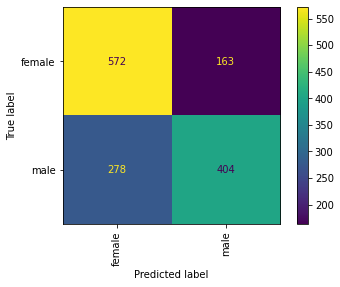

In [27]:
skl.train()

In [20]:
bert = TFExperiment('/content/drive2/MyDrive/pan17-author-profiling-training-dataset-2017-03-10/en/df_gender1_2k.csv', 0.1, "texts", "gender")

https://app.neptune.ai/c0pper/fake-news/e/FAK-14
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


Dataset head

   Unnamed: 0                                              texts  gender
0           0  @TazzasaurusRex '05 Audi A4 Avant with only 60...  female
1           1  @TazzasaurusRex nah it's not a write off, gett...  female
2           2  @TazzasaurusRex ya both have been a long time ...  female
3           3                               @TazzasaurusRex who?  female
4           4  Probably my favourite post on reddit ever http...  female
Dataset class distribution:
male 600
female 600

Preprocessing texts...

Before: Top Sensual Experience in Sydney: Lace | @scoopit ..


100%|██████████| 120/120 [00:00<00:00, 4529.20it/s]



After: top sensual experience sydney lace scoopit


  0%|          | 0/1080 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 120/120 [00:00<00:00, 2094.42it/s]
Some lay

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 60)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                          

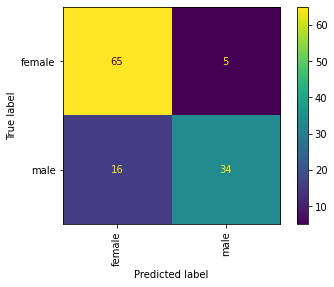

In [21]:
bert.train(epochs=1,)

In [12]:
nb_url = "https://colab.research.google.com/drive/" + get('http://172.28.0.2:9000/api/sessions').json()[0]["path"].split("=")[-1]
nb_url

'https://colab.research.google.com/drive/13pPw5eGVjETagjrCD3sVkS8OkPrkvMnm'

In [5]:
fn20k = pd.read_csv("/content/drive2/MyDrive/simo/datasets/fake_news/fn20k_stil.csv")


In [9]:
stylo = StyloExperiment(fn20k, split_size=0.1, target_col="Target")

Dataset name not found. Please enter dataset name: yyy
https://app.neptune.ai/c0pper/fake-news/e/FAK-22
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [3]:
stylo.train(epochs=1)

NameError: ignored

              precision    recall  f1-score   support

        real       0.92      0.88      0.90     23343
        fake       0.88      0.92      0.90     21417

    accuracy                           0.90     44760
   macro avg       0.90      0.90      0.90     44760
weighted avg       0.90      0.90      0.90     44760

Time elapsed in seconds:  5.46
Stop neptune traking? Continue if you want to do evaluation (y/n)n
Continuing neptune tracking


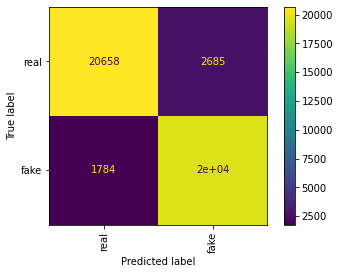

In [10]:
stylo.evaluate_on_other_dataset("/content/drive2/MyDrive/simo/datasets/fake_news/fn44k_stil.csv", 
                                     '/content/drive2/MyDrive/simo/models/stylo/fake_news__merged[welfake,fn20k,fn44k]__Sequential_stilometria.pkl', "Target")